In [35]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


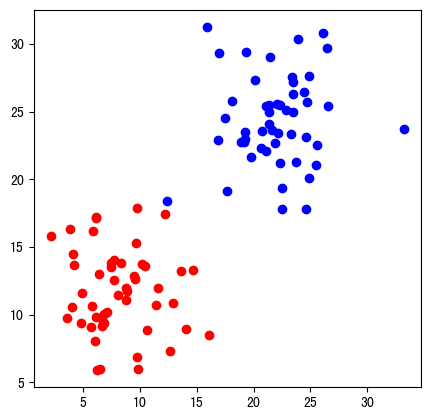

In [176]:
# 获取数据集（具有正态分布的）
x_1_1 = pd.Series(np.random.normal(loc=22, scale=4, size=50), name='x1')
x_1_2 = pd.Series(np.random.normal(loc=24, scale=4, size=50), name='x2')
y_1 = pd.Series(['blue'] * 50, name='target')

x_2_1 = pd.Series(np.random.normal(loc=8, scale=3, size=50), name='x1')
x_2_2 = pd.Series(np.random.normal(loc=12, scale=3, size=50), name='x2')
y_2 = pd.Series(['red'] * 50, name='target')

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(x_1_1, x_1_2, c='blue')
plt.scatter(x_2_1, x_2_2, c='red')
plt.show()

tmp_data_1 = pd.concat([x_1_1, x_1_2, y_1], axis=1)
tmp_data_2 = pd.concat([x_2_1, x_2_2, y_2], axis=1)
data = pd.concat([tmp_data_1, tmp_data_2], axis=0)
data = shuffle(data).reset_index(drop=True)  # 打乱样本顺序

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1])

# 归一化
transfer = MinMaxScaler(feature_range=(0, 10))
x_train = transfer.fit_transform(X=x_train)
x_test = transfer.transform(X=x_test)


# CUC 的主类

In [301]:
class CodingUnitClassifier(object):
    '编码单元分类器预估器（estimator）'
    def __init__(self, num_continuing_splits=0, threshold_value=1.0, is_draw_2D=False, **kw) -> None:
        """初始化

        Args:
            num_continuing_splits (int, optional): 细化分割次数. Defaults to 0.
            threshold_value (int, optional): 临界值. Defaults to  1.0.
            is_draw_2D (bool, optional): 当绘制 2D 数据集，是否绘制中途图像. Defaults to False.
        """
        self.is_draw_2D = is_draw_2D
        self.num_continuing_splits = num_continuing_splits
        self.threshold_value = threshold_value  # 临界值：当某个 CU 中某种粒子占比超过这个阈值，则暂停分割
        
        self.N_train = None  # 训练集的维度
        self.X_train = None  # 特征值（训练集）
        self.y_train = None  # 目标值（训练集）
        self.df_train = None  # 以 pandas.DataFream 形式的训练接数据（特征值和训练集是合并在一起的）。目标值的索引为 `target`，特征值的索引为 `x`，x 为从 0 开始的数字
        
        self.CU_min = None  # 编码单元范围最小值
        self.CU_max = None  # 编码单元范围最小值
        
        self.arr_CU_start_points = None  # 编码单元起始点列表
        self.arr_CU_dL = None # arr_CU_start_points 对应位置的编码单元的边长 `dL`
        self.arr_CU_is_enable = None  # arr_CU_start_points 对应位置的编码单元是否启用，True 代表启用，False 代表不启用
        self.arr_CU_splits_count = None  # arr_CU_start_points 对应位置的编码单元是通过几次分割所得到的
        self.arr_CU_is_final = None  # arr_CU_start_points 对应位置的编码单元是否为最终的
        self.arr_CU_force_infection = None  # arr_CU_start_points 对应位置的编码单元的感染力度 (force of infection)

        
    def is_CU_need_split(self, CU_start_points: np.ndarray, dL: np.float):
        """判断当前 CU 是否需要继续预分割（如果需要返回 True，如果不需要返回当前 CU 所属的目标值）

        Args:
            CU_start_points (np.ndarray): 当前 CU 的起始点
            dL (np.float): 当前 CU 的边长

        Raises:
            ValueError: _description_
            ValueError: _description_

        Returns:
            _type_: True为需要进一步分割，如果不需要返回当前 CU 所属的目标值
        """
        if dL <= 0:
            raise ValueError(f'[CUC-ERROR] dl can not <= 0, your dL is {dL}')
        if CU_start_points.shape[0] != 1 or CU_start_points.shape[1] != self.N_train:
            raise ValueError(f'[CUC-ERROR] CU_start_points.shape not correct: CU_start_points.shape is {CU_start_points.shape}, should be (1, {self.N_train})')
        
        CU_end_points = np.array(CU_start_points + dL)  # 结束点
        s_type_count = pd.Series(index=np.unique(self.y_train)).fillna(value=0)  # 计数器，列索引为类别，对应位置数据为该 CU 中此种类粒子数量
        
        # 遍历判断点是否在这个 CU  中
        for col, col_target in zip(self.X_train, self.y_train):  # col_target 为当前行的目标值
            # 判断粒子在此维度上是否介于 CU 的起始点和结束点
            if (col > CU_start_points).all() & (col < CU_end_points).all():
                s_type_count[col_target] += 1
                
        s_type_count = s_type_count / s_type_count.sum()  # 转换为概率
        if (s_type_count.max() >= self.threshold_value) & (1 == s_type_count[s_type_count.values == s_type_count.max()].shape[0]):  # 不允许出现两种相同概率
            return s_type_count[s_type_count.values == s_type_count.max()].index[0]
        else:
            return True
        
        
    def split_CU_and_update2arrCU(self, CU_start_points_index: int) -> None:
        """分割当前 CU，并将分割的结果更新到方法内部成员

        Args:
            CU_start_points_index (int): 需要分割 CU 的索引
        """
        if self.arr_CU_is_enable[CU_start_points_index] is False:
            raise ValueError(f'[CUC-ERROR] CU on index {CU_start_points_index} already disable, can not continue split')
        
            
        self.arr_CU_is_enable[CU_start_points_index] = False  # 既然对这个单元分割就说明这个单元不再使用了，因为它被差分成了许多新的小单元
        
        start_points = self.arr_CU_start_points[CU_start_points_index, :]
        new_dL = self.arr_CU_dL[CU_start_points_index] / 2
        end_points = np.array(start_points + new_dL)
        
        # 生成包含所有可能性组合的列表
        combinations = []
        for i in range(2**self.N_train):
            new_combination = []
            for j in range(self.N_train):
                if i & (1<<j):
                    new_combination.append(end_points[j])
                else:
                    new_combination.append(start_points[j])
            combinations.append(new_combination)
            
        # 分割后的 CU 添加至缓冲区
        self.arr_CU_start_points = np.vstack([self.arr_CU_start_points, np.array(combinations)])
        self.arr_CU_dL = np.vstack([self.arr_CU_dL, np.full(shape=(2**self.N_train, ), fill_value=new_dL)])
        self.arr_CU_is_enable = np.vstack([self.arr_CU_is_enable, np.full(shape=(2**self.N_train, ), fill_value=True)])
        self.arr_CU_splits_count = np.vstack([self.arr_CU_splits_count, np.full(shape=(2**self.N_train, ), fill_value=self.arr_CU_splits_count[CU_start_points_index] + 1)])
        self.arr_CU_is_final = np.vstack([self.arr_CU_is_final, np.full(shape=(2**self.N_train, ), fill_value=False)])
        
            

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """编码单元分类器的估计器（estimator）

        Args:
            X (np.ndarray): 特征值
            y (np.ndarray): 目标值

        Raises:
            ValueError: _description_
        """ 
        # 如果特征值和目标值维度相等
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'[CUC-ERROR] X.shape != y.shape: X.shape is {X.shape[0]}, y.shape is {y.shape[0]}')
        
        # 初始化 CUC 配置参数
        self.N_train = X.shape[1]
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.df_train = pd.concat([pd.DataFrame(self.X_train), pd.Series((self.y_train), name='target')], axis=1)
        
        self.CU_min = X.min()
        self.CU_max = X.max()
                
        # 初始化 CU 相关 ndarray
        self.arr_CU_start_points = np.full(shape=(1, self.N_train), fill_value=self.CU_min)  # 将初始化中的 0.0 替换为编码单元的起始点
        self.arr_CU_dL = np.array([self.CU_max - self.CU_min])
        self.arr_CU_is_enable = np.array([True])
        self.arr_CU_splits_count = np.array([0])
        self.arr_CU_is_final = np.array([False])
        self.arr_CU_force_infection = np.array([-1])
        
        current_index = 0
        while (current_index < self.arr_CU_start_points.shape[0]):
            # 如果当前 CU 已经废弃（disable），那么就没有再对他进行处理的意义了
            
            
            type_split = self.is_CU_need_split(CU_start_points=self.arr_CU_start_points[current_index, :],
                                               dL=self.arr_CU_dL[current_index])
            if type_split is not True:
                self.arr_CU_is_final[current_index] = True
                
                pass
            current_index += 1
            pass

In [227]:
estimator = CodingUnitClassifier()
estimator.fit(X=x_train, y=y_train)

In [321]:
type(np.vstack([np.zeros((2, 5)), np.ones((3, 5))]))

numpy.ndarray

In [323]:
np.full(shape=(2,), fill_value=3.33)

array([3.33, 3.33])

In [242]:
np.unique(estimator.y_train)

array(['blue', 'red'], dtype=object)

In [261]:
tt = pd.Series(index=np.unique(estimator.y_train)).fillna(value=0)
tt['red'] += 1
tt['blue'] += 3

/var/folders/8w/gbcdx24135zfcng_1h_r02jw0000gn/T/ipykernel_68659/4224513197.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tt = pd.Series(index=np.unique(estimator.y_train)).fillna(value=0)


绘制 CU

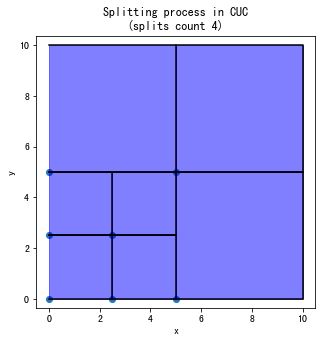

In [54]:
# 第一为：CU起始点的x
# 第二为：CU起始点的y
# 第三为：CU 的边长
data = np.array([
    [0,   0,   2.5],
    [2.5, 0,   2.5],
    [0,   2.5, 2.5],
    [2.5, 2.5, 2.5],
    [0,   5,   5],
    [5,   0,   5],
    [5,   5,   5]])

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1])
# plt.show()

num = 4

# plt.figure()
for i in data:
    t_x_block = [i[0], i[0]+i[2], i[0]+i[2], i[0]]
    t_y_block = [i[1], i[1],      i[1]+i[2], i[1]+i[2]]
    plt.plot(t_x_block, t_y_block, c='black')
    plt.fill(t_x_block, t_y_block, c='b', alpha=0.5)
    plt.title(f'Splitting process in CUC\n(splits count {num})')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.axis('equal')  # x、y 单位长度等长
    
plt.show()

In [314]:
def generate_combinations(arr1, arr2):
    # 获取数组长度
    n = len(arr1)
    # 生成包含所有可能性组合的列表
    combinations = []
    for i in range(2**n):
        new_combination = []
        for j in range(n):
            if i & (1<<j):
                new_combination.append(arr2[j])
            else:
                new_combination.append(arr1[j])
        combinations.append(new_combination)
    return combinations


In [315]:
generate_combinations(["0", "0"], ["1", "1"])

[['0', '0'], ['1', '0'], ['0', '1'], ['1', '1']]

In [ ]:
# 1. 归一化

# 2. 划分数据集

# 

array([0.03706571, 0.05368892, 0.01749104, ..., 0.00729749, 0.01039707,
       0.00729749])